# Neural Style Transfer

We'll describe an implementation of DeepDream.

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

In [1]:
from PIL import Image

image = Image.open("image.png").convert('RGB').resize((256, 256))

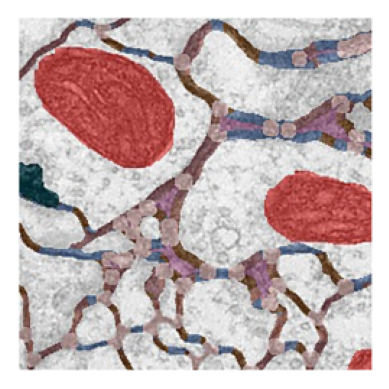

In [2]:
from matplotlib import pyplot as plt

plt.imshow(image)
plt.axis('off')
plt.show()

We'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona)

In [3]:
style = Image.open("style.png").convert('RGB').resize((256, 256))

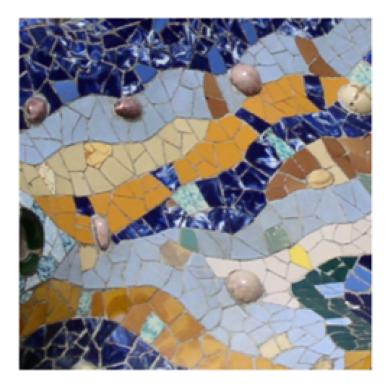

In [4]:
plt.imshow(style)
plt.axis('off')
plt.show()

We'll define a funtion for calculating the Gram matrix between all the features of a specific layer.

Gramm matrix represents the correlations between different feature maps of a layer

In [5]:
from torch import bmm

def gram_matrix(tensor):
    # Unpack the dimensions of the input tensor
    batch_size, num_channels, height, width = tensor.size()

    # Reshape the tensor so it's a 2D matrix, with channels as features and height*width as observations
    features = tensor.view(batch_size, num_channels, height * width)

    # Compute the Gram matrix as the product of the matrix by its transpose
    # Normalizing by the number of elements in each feature map (height*width)
    gram = bmm(features, features.transpose(1, 2)) / (height * width)

    return gram

We'll download a pretrained model (VGG16) and freeze all the weights.

In [6]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset.

We'll define a function that minimize the style and content losses with respect to the reference images. 

In [7]:
def preprocess(image, mean_ds, std_ds):
    import torch 
    from torchvision import transforms
    normalize = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=mean_ds,
                                 std=std_ds),
                            ])
    tensor = normalize(image).unsqueeze(0).requires_grad_(True)
    return tensor

In [8]:
def deprocess(tensor, mean_ds, std_ds):
    import numpy as np
    from torchvision import transforms
    denormalize = transforms.Normalize(mean = -mean_ds/std_ds, 
                                    std = 1/std_ds )
    im = np.array(denormalize(tensor.detach().squeeze())).transpose(1,2,0)
    return im

In [9]:
import numpy as np
import torch
import torchvision.transforms as tt
from PIL import Image
from fnc_style_transfer import fwd_hooks

def style_transfer(im_in, im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 1e3, iter_num=100):
    # Normalization parameters typically used with pretrained models
    mean_ds = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std_ds = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    # image
    image_c = preprocess(im_c, mean_ds, std_ds)

    with fwd_hooks(layers) as fh:
        _ = model(image_c)
    content_features = [fh.stored[i].detach() for i in ind_c]

    # style
    image_s = preprocess(im_s, mean_ds, std_ds)

    with fwd_hooks(layers) as fh:
        _ = model(image_s)
    style_features = [fh.stored[i].detach() for i in ind_s]
    gram_targets = [gram_matrix(s) for s in style_features]

    #input
    try: im_in.verify()
    except: 
        print('Input image not provided. Using a random input.')
        imarray = np.random.rand(*image_size, 3) * 255
        im_in = Image.fromarray(imarray.astype('uint8')).convert('RGB')
    
    image_in = preprocess(im_in, mean_ds, std_ds)#.requires_grad_(True)
    
    optimizer = torch.optim.LBFGS([image_in], lr=lr)
    mse_loss = torch.nn.MSELoss(reduction='sum')

    l_c = []
    l_s = []

    for it in range(iter_num):
        def closure():
            optimizer.zero_grad()

            # content & style
            with fwd_hooks(layers) as fh:
                out = model(image_in)
            content_features_in = [fh.stored[i] for i in ind_c]
            style_features_in = [fh.stored[i] for i in ind_s]
            gram_in = [gram_matrix(i) for i in style_features_in]

            c_loss = 0
            for i,c in enumerate(content_features_in):
                n_f = c.shape[1]
                c_loss += mse_loss(c,content_features[i])/n_f**2
            c_loss /= len(content_features_in)

            s_loss = 0
            for i,g in enumerate(gram_in):
                n_g = g.shape[1]
                s_loss += mse_loss(g,gram_targets[i])/n_g**2
            s_loss /= len(gram_in)

            loss = c_loss + beta*s_loss
            l_c.append(c_loss)
            l_s.append(s_loss)

            loss.backward()
            return loss

        optimizer.step(closure)
        print('Step {}: Content Loss: {:.8f} Style Loss: {:.8f}'.format(it, l_c[-1], l_s[-1]))

        # if (it)%10 == 0:
        #     im_out = Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB') 
        #     plot_style(im_c, im_s, im_out)
    return Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone(), mean_ds, std_ds)*255,0,255)), 'RGB')

We'll apply the style transfer using as an input the same image used to get the content.

In [10]:
def plot_style(im_c, im_s, im_out):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5)) 
    plt.subplot(1, 3, 1)
    plt.imshow(im_c)
    plt.title('Content image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(im_s)
    plt.title('Style image') 
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(im_out)
    plt.title('Output image') 
    plt.axis('off')
    plt.show()

Step 0: Content Loss: 145.23857117 Style Loss: 0.19456711
Step 1: Content Loss: 190.81840515 Style Loss: 0.07634427
Step 2: Content Loss: 210.78025818 Style Loss: 0.04676365
Step 3: Content Loss: 220.46885681 Style Loss: 0.03409965
Step 4: Content Loss: 228.97715759 Style Loss: 0.02282757


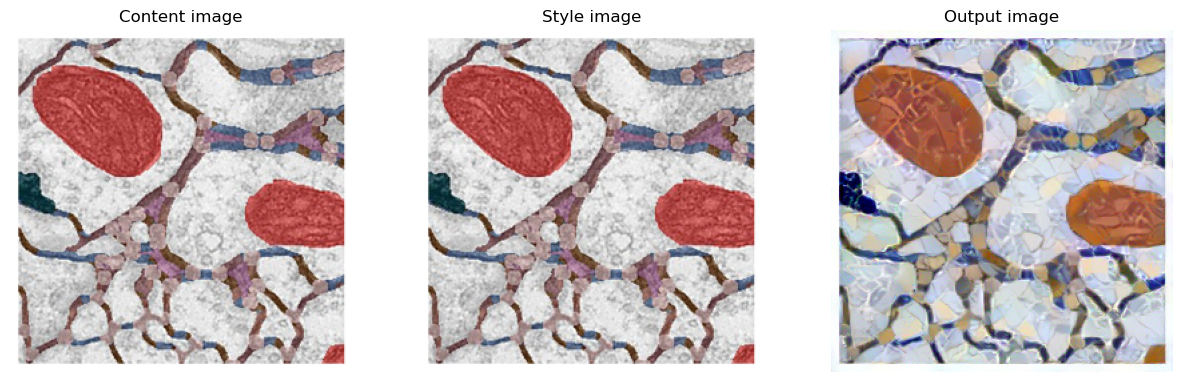

In [11]:
#from style_transfer import plot_style

ind = [0, 2, 5, 7, 10, 14]
layers = [model.features[i] for i in ind ] 
ind_c = [5]
ind_s = [0, 1, 2, 3, 4]

im_out  =  style_transfer(image, image, style, layers, ind_c, ind_s, lr=1, beta=1e5, iter_num=50)
plot_style(image, image, im_out)

We'll also apply the style transfer using as an input a random image.

In [12]:
im_out  =  style_transfer([], image, style, layers, ind_c, ind_s, lr = 1, beta = 1e4, iter_num=200)
plot_style(image, style, im_out)

Input image not provided. Using a random input.


NameError: name 'image_size' is not defined